# Задание 7
https://drive.google.com/file/d/156K2MIDP3UqRc5qkH0VpI9IXhWTA-o6G/view?usp=sharing
Задана выборка пар изображений images.zip: каждая пара состоит из оригинального (original_id.bmp) изображения и искаженного (modified_id_phrase.bmp).
Также задана пара контрольных изображений original_test, modified_test.

В 99% случаев искажение заключается в добавлении шума. В 1% случаев искажение заключается в добавлении к изображению скрытого сообщения. 
Алгоритм заключается в следующем:
1. У исходной фразы берутся порядковые номера всех символов в порядке английского алфавита (abcz -> 0,1,2,25).
2. Полученный вектор домножается на неизвестный коэффициент alpha и складывается с вектором картинки (image = image.flatten() + alpha*v).
3. Если фраза слишком короткая, искажение продолжается периодически.

Требуется раскодировать фразу из контрольной пары.
NB: предполагается, что вы найдете искаженные изображения без шума с применением статистических моделей, а не перебором.

## Ссылки
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.misc.imread.html
* https://docs.python.org/3/library/functions.html#ord

# Решение

Решение разделено на две основные части: нахождение картинок с зашифрованым сообщением и определение константы alpha.

### Подготовка

In [1]:
from scipy import misc
import glob
import matplotlib.pyplot as plt
import numpy as np

Достанем список названий файлов

In [2]:
out = !dir images_full\images\modified*.bmp
mnames = [x[x.rfind(' ') + 1:] for x in out][5:-2]
out = !dir images_full\images\original_*.bmp
onames = [x[x.rfind(' ') + 1:] for x in out][5:-2]

считаем изображения

In [3]:
path = 'images_full/images/'
original_imgs = []
for x in onames:
    original_imgs.append(misc.imread(path + x, )) 
modified_imgs = []    
for x in mnames:
    modified_imgs.append(misc.imread(path + x)) 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


### Нахождение картинок с шифром

Найдем разницу между оригинальными и тестовыми изображениями. Мы прибавляем 100 чтобы избежать переполнения формата uint8 

In [4]:
diff = [modified_imgs[i] - original_imgs[i] + 100 for i in range(len(modified_imgs))]

Предполагаем, что у шума нулевое мат ожидание и одинаковая, небольшая дисперсия. Посмотрим на их распределения:

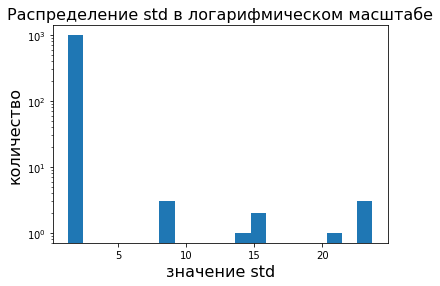

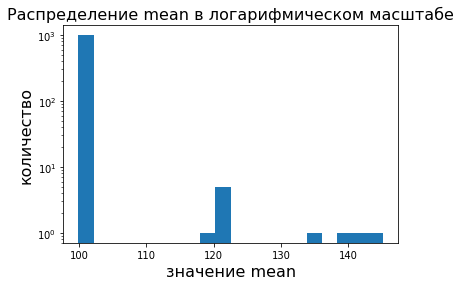

In [5]:
std_list = [diff[i].std() for i in range(len(diff))]
mean_list = [diff[i].mean() for i in range(len(diff))]
plt.title('Распределение std в логарифмическом масштабе', fontsize=16)
plt.xlabel('значение std', fontsize=16)
plt.ylabel('количество', fontsize=16)
plt.hist(std_list, log=True, bins=20)
plt.show()

plt.title('Распределение mean в логарифмическом масштабе', fontsize=16)
plt.xlabel('значение mean', fontsize=16)
plt.ylabel('количество', fontsize=16)
plt.hist(mean_list, log=True, bins=20)
plt.show()

Видим, что все картинки разделяются этими гистограммами на два класса, причем один из них совпадает по свойствам с нашими предположениями о шуме. А также содержит большинство объектов выборки.

отделим эти классы по гистограмме std

In [6]:
cript = [i for i in range(len(modified_imgs)) if (diff[i].std() > 1.5)]

Посмотрим на элементы из обоих классов:

без зашифрованой фразы

mean = 99.997314453125
std = 1.3489154406273887


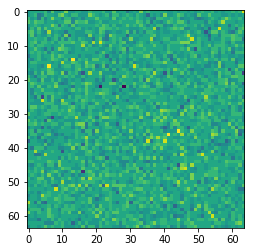

In [7]:
print('mean =', diff[0].mean())
print('std =', diff[0].std())
plt.imshow(diff[0])
plt.show()

с зашифрованной фразой

mean = 145.13427734375
std = 14.877462928493737


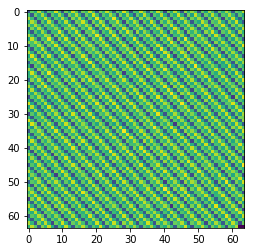

In [8]:
print('mean =', diff[50].mean())
print('std =', diff[50].std())
plt.imshow(diff[50])
plt.show()

Видим, что наше предположение оказалось верным.

Значит мы можем отрезать по std нужные нам графики.

### Нахождение alpha

найдем из названий файлов список зашифрованных слов.

In [9]:
words = [mnames[j][mnames[j].rfind('_') + 1:-4] for j in range(len(mnames))]

Сгенерируем выборку для построения регрессии. 

иксы - коды букв\\
игрики - значения из картинки

In [10]:
X = []
Y = []
for j in cript:
    for i, x in enumerate(diff[j].flatten()):
        X.append(ord(words[j][i % len(words[j])]) - ord('a'))
        Y.append(x)
        
X = np.array(X)
Y = np.array(Y, dtype=np.int32) - 100        

Найдем коэффицент регрессии в предположении, что шум нормальный с нулевым матожиданием.

In [11]:
alpha = X.T.dot(Y) / X.dot(X)
print('alpha =',alpha)

alpha = 3.1337908471296996


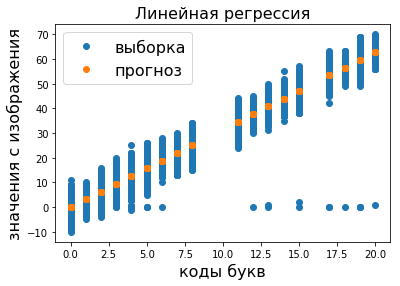

In [12]:
plt.title('Линейная регрессия', fontsize=16)
plt.xlabel('коды букв', fontsize=16)
plt.ylabel('значения с изображения', fontsize=16)
plt.plot(X, Y, "o", label='выборка')
plt.plot(X, X*alpha, "o", label='прогноз')
plt.legend(fontsize=16)

Выглядит норм. Выбросы внизу похоже обусловлены тем, что при записывании фразы в картинку, в случае, если целое слово не влезало, то генерировались символы 'a'

Предполагая, что alpha целое предположим что оно 3

### Расшифруем тест

In [13]:
path = 'images_full/'
original_test = misc.imread(path + 'original_test.bmp')
modified_test = misc.imread(path + 'modified_test.bmp')
test_diff = modified_test - original_test

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
def translator(alpha, diff):
    word = ''
    for x in diff:
        word += chr(ord('a') + int(x / alpha))
    return word
    
translator(3, test_diff.flatten())

'xheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemoneuleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonexleboxskixheresuhemonezleboxskirheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhemonezleboxskixheresuhe

### Вывод

Можем прочитать фразу "Where's the money, Lebowski?"

Значит мы правильно подобрали alpha.

Видим, что фраза востановлена не идеально. Это связано с шумом наложенным на картинку(помимо зашифровки сообщения). 

Так же мы видим, что без догадывания мы не можем однозначно востановить фразу, тк в каждом повторе фразы "ошибки" в одних и тех же буквах. Возможно это связано с природой генирации шума(если он был сгенерирован не для картинки, а для фразы). 

В ином случае нам бы следовало с помощью построения временного ряда или "на глаз" найти период фразы и найти argmax по числу вхождений буквы для каждого места в фразе.